In [4]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_selection import mutual_info_regression 
from sklearn.inspection import permutation_importance
from sklearn.linear_model import LinearRegression
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.metrics import PredictionErrorDisplay
from statsmodels.stats.outliers_influence import variance_inflation_factor
import joblib

In [5]:
filepath = "data/housing.csv" 
data = pd.read_csv(filepath) 
data.shape

(20640, 10)

In [6]:
data.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


## Exploratory analysis
### Null values

In [7]:
data.isna().sum()

longitude               0
latitude                0
housing_median_age      0
total_rooms             0
total_bedrooms        207
population              0
households              0
median_income           0
median_house_value      0
ocean_proximity         0
dtype: int64

### Target

In [8]:
y = data.median_house_value

<Axes: xlabel='median_house_value', ylabel='Count'>

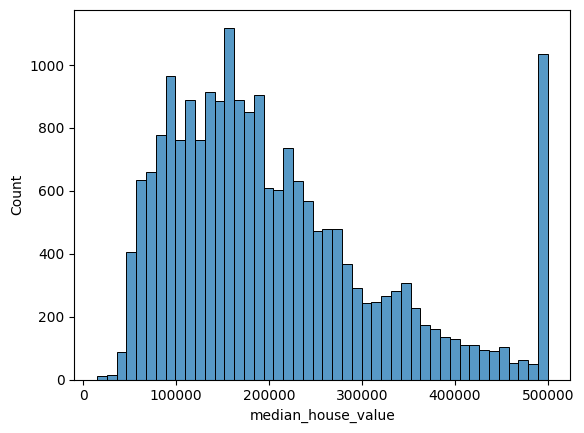

In [9]:
sns.histplot(y)

### Features

In [10]:
X = data.drop('median_house_value', axis=1)
X_cont = X.select_dtypes(include=['int64', 'float64'])
X_cat = X.select_dtypes(include=['object'])

#### Categorical

In [11]:
X_cat.value_counts()

ocean_proximity
<1H OCEAN          9136
INLAND             6551
NEAR OCEAN         2658
NEAR BAY           2290
ISLAND                5
Name: count, dtype: int64

<Axes: xlabel='ocean_proximity', ylabel='count'>

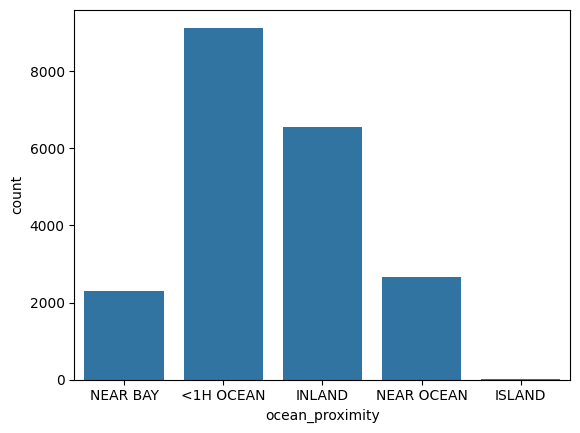

In [12]:
sns.countplot(x='ocean_proximity', data=data)

#### Continuous

In [13]:
X_cont.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462


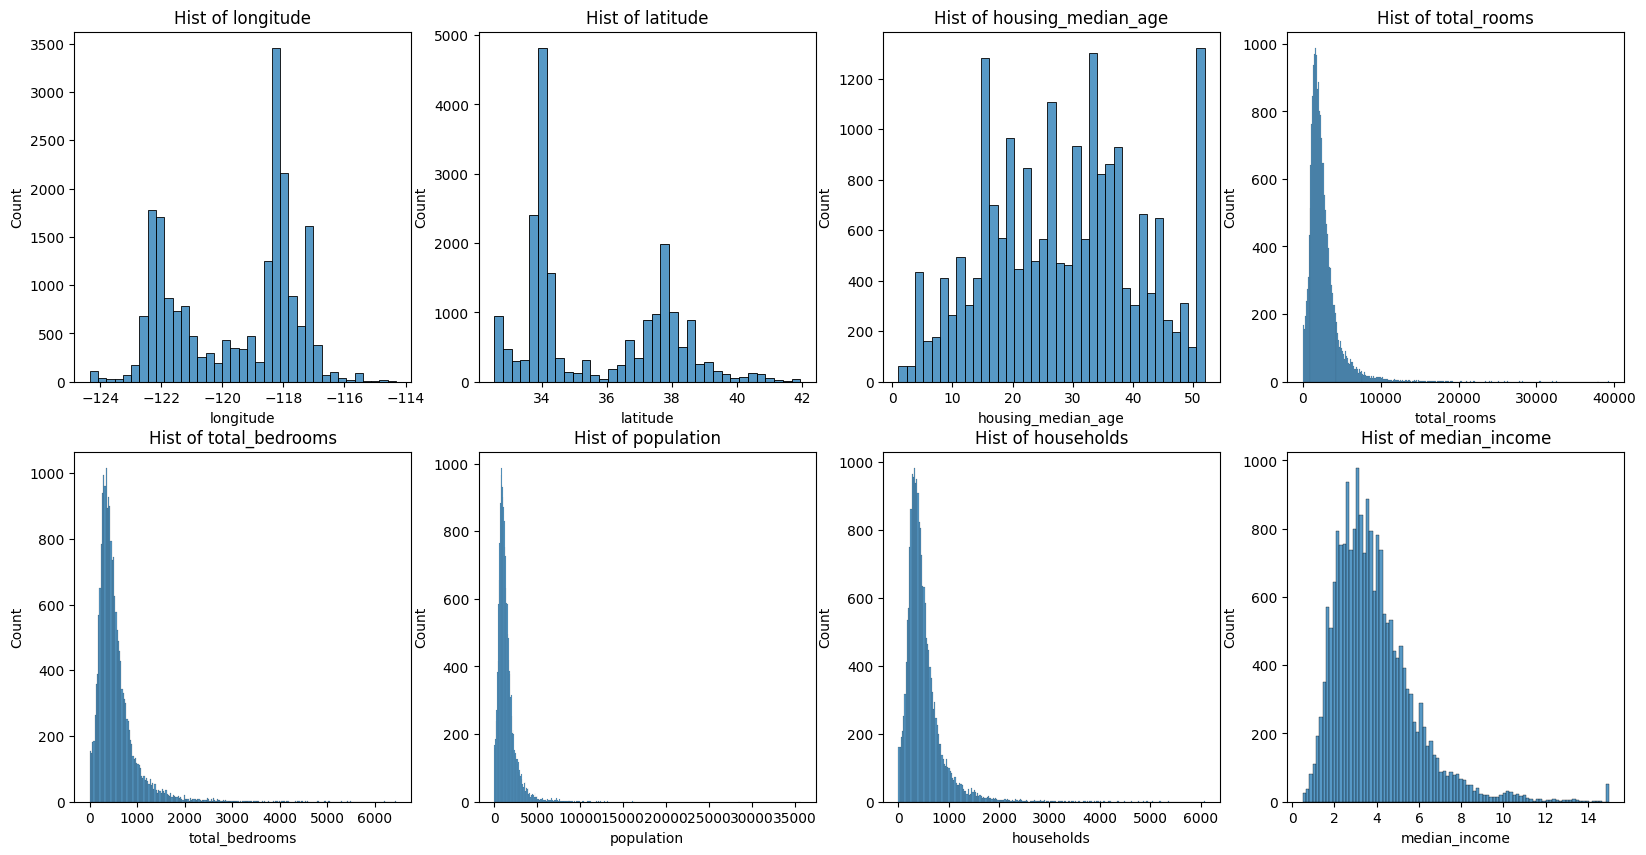

In [14]:
fig, axes = plt.subplots(nrows=2, ncols=len(X_cont.columns)//2, figsize=(20, 10))
axes = axes.flatten()

for i, col in enumerate(X_cont.columns):
    sns.histplot(x=X[col], ax=axes[i])
    axes[i].set_title(f'Hist of {col}')

plt.show()

### Joint distributions

#### Categorical

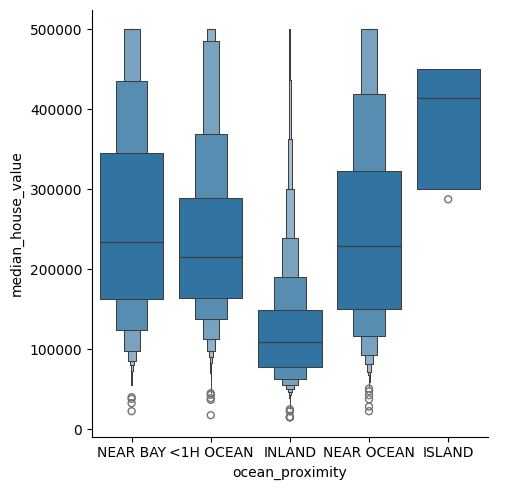

In [15]:
sns.catplot(x="ocean_proximity", y="median_house_value", kind="boxen",
            data=data)

<Axes: xlabel='median_house_value', ylabel='ocean_proximity'>

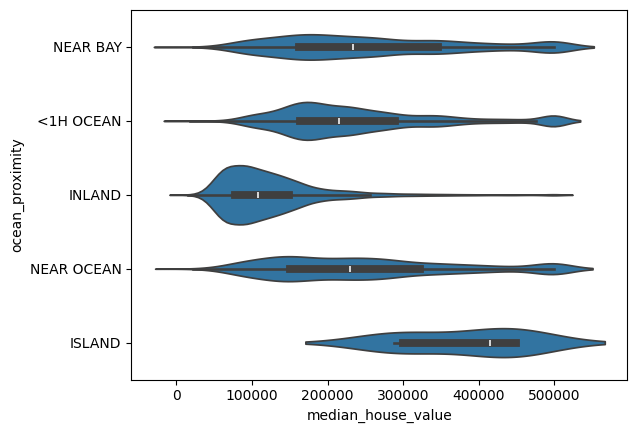

In [16]:
sns.violinplot(x=data.median_house_value, y=data.ocean_proximity)

#### Quantitative

<Axes: >

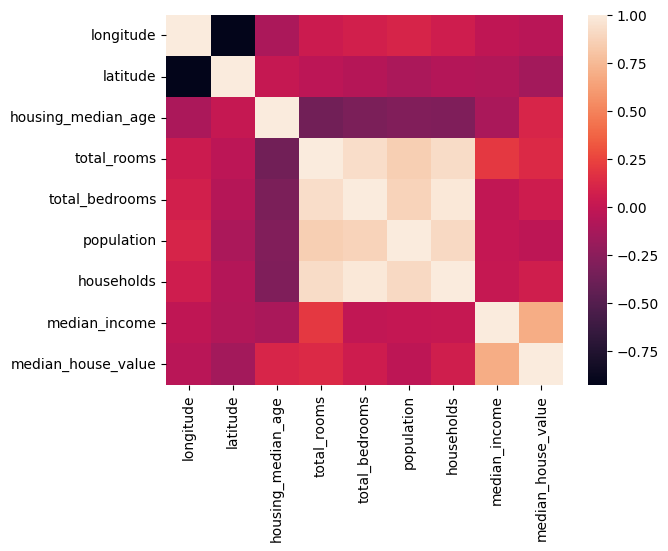

In [17]:
corr = data.select_dtypes('number').corr()
sns.heatmap(corr)

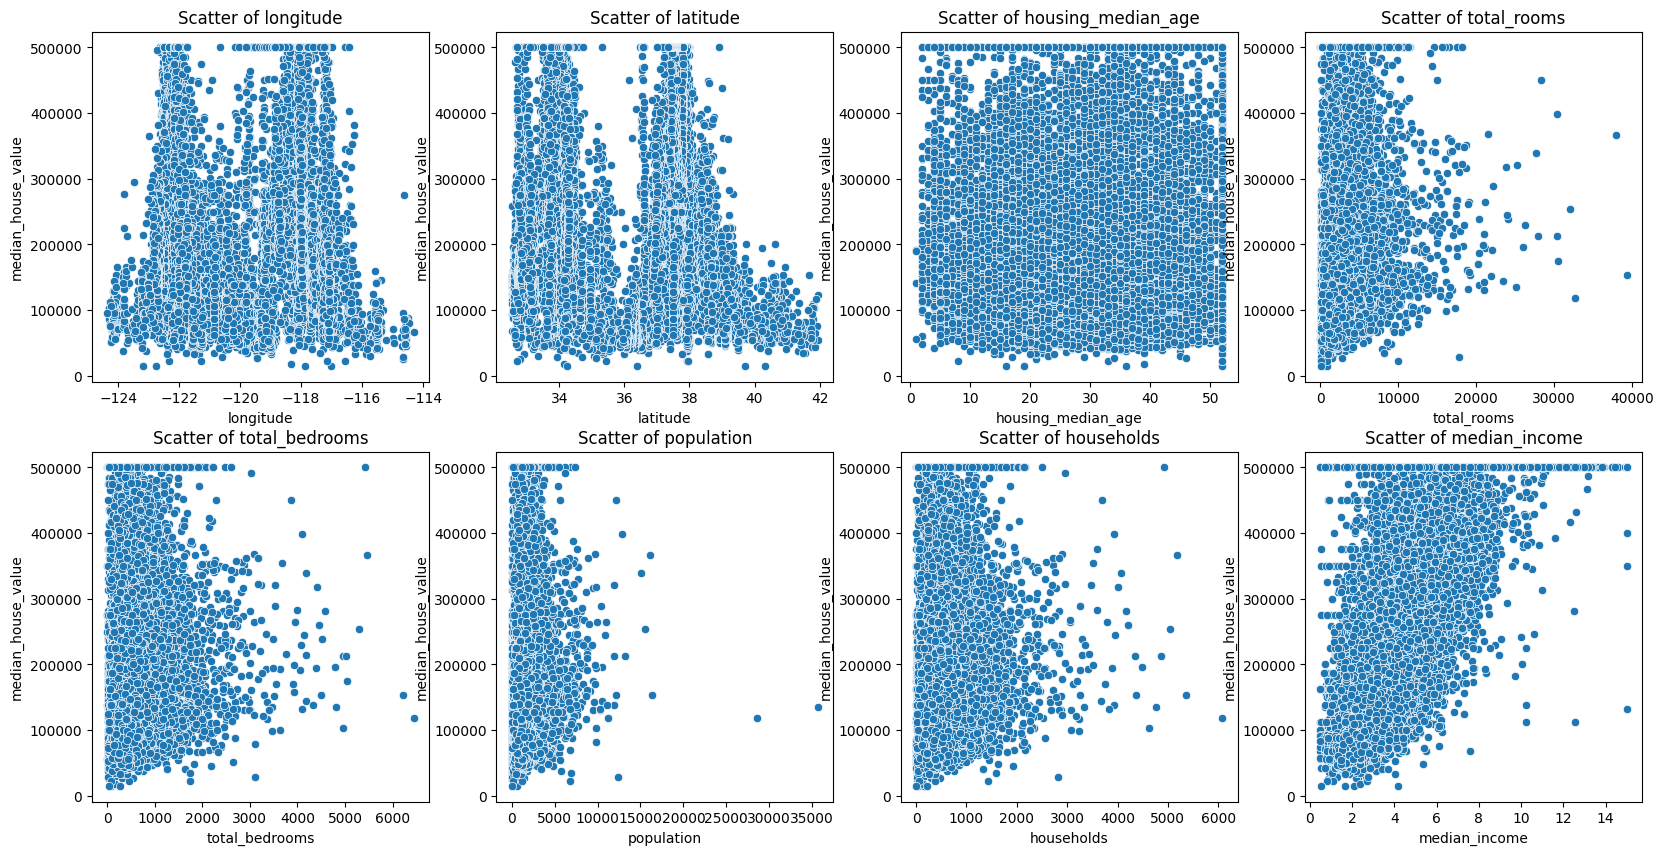

In [18]:
fig, axes = plt.subplots(nrows=2, ncols=len(X_cont.columns)//2, figsize=(20, 10))
axes = axes.flatten()

for i, col in enumerate(X_cont.columns):
    sns.scatterplot(data=data, x=col, y="median_house_value", ax=axes[i])
    axes[i].set_title(f'Scatter of {col}')

plt.show()

## Feature engineering

### Feature selection

In [19]:
def get_mi_scores(X, y, discrete_features) :
    mi_scores = mutual_info_regression(X=X, y=y, discrete_features=discrete_features)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores

def plot_mi_scores(mi_scores) :
    mi_scores = mi_scores.sort_values(ascending=True)
    width = np.arange(len(mi_scores)) # return evenly spaced values within a given range
    ticks = list(mi_scores.index)
    plt.barh(width, mi_scores)
    plt.yticks(width, ticks)
    plt.title("Mutual Information Scores")
    plt.show()

In [20]:
X_MI = X.dropna(axis=1, how='any')
list(set(X.columns) - set(X_MI.columns))

['total_bedrooms']

E:\temp_folders\Temp\ipykernel_19688\4249783444.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_MI[colname], _ = X_MI[colname].factorize() # factorize returns a numeric representation of an array (what matters is identifying different values), it returns a tupples (codes, unique values) and here we are interested only in the codes


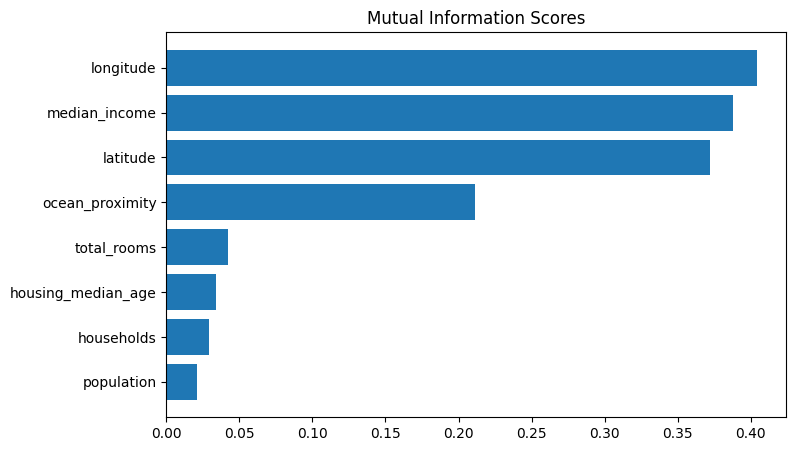

In [21]:
for colname in X_MI.select_dtypes("object") :
    X_MI[colname], _ = X_MI[colname].factorize() # factorize returns a numeric representation of an array (what matters is identifying different values), it returns a tupples (codes, unique values) and here we are interested only in the codes
discrete_features = X_MI.dtypes == int # this is to check that all discrete features are of type int now after the encoding
mi_scores = get_mi_scores(X=X_MI, y=y, discrete_features=discrete_features)
mi_scores[::3]
plt.figure(dpi=100, figsize=(8, 5))
plot_mi_scores(mi_scores=mi_scores)

In [22]:
data_mi = data[['total_bedrooms', 'median_house_value']].dropna()
mi_scores_na = get_mi_scores(X=data_mi[['total_bedrooms']], y=data_mi['median_house_value'], discrete_features='auto')
mi_scores_na

total_bedrooms    0.026051
Name: MI Scores, dtype: float64

### Feature preprocessing

In [23]:
preprocessor = ColumnTransformer(
            transformers = [
                ('median_impute', SimpleImputer(strategy='median'), ['total_bedrooms']),
                ('one_hot', OneHotEncoder(handle_unknown='ignore', sparse_output=False), X_cat.columns)
            ],
            remainder='passthrough'
        )
preprocessor.set_output(transform='pandas')

ColumnTransformer(remainder='passthrough',
                  transformers=[('median_impute',
                                 SimpleImputer(strategy='median'),
                                 ['total_bedrooms']),
                                ('one_hot',
                                 OneHotEncoder(handle_unknown='ignore',
                                               sparse_output=False),
                                 Index(['ocean_proximity'], dtype='object'))])

In [24]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, train_size=0.8, test_size=0.2, random_state=0)

In [25]:
X_train.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity
12069,-117.55,33.83,6.0,502.0,76.0,228.0,65.0,4.2386,INLAND
15925,-122.44,37.73,52.0,2381.0,492.0,1485.0,447.0,4.3898,NEAR BAY
11162,-118.00,33.83,26.0,1718.0,385.0,1022.0,368.0,3.9333,<1H OCEAN
4904,-118.26,34.01,38.0,697.0,208.0,749.0,206.0,1.4653,<1H OCEAN
4683,-118.36,34.08,52.0,2373.0,601.0,1135.0,576.0,3.1765,<1H OCEAN


In [26]:
X_valid.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity
14740,-117.05,32.58,22.0,2101.0,399.0,1551.0,371.0,4.1518,NEAR OCEAN
10101,-117.97,33.92,32.0,2620.0,398.0,1296.0,429.0,5.7796,<1H OCEAN
20566,-121.84,38.65,29.0,3167.0,548.0,1554.0,534.0,4.3487,INLAND
2670,-115.60,33.20,37.0,709.0,187.0,390.0,142.0,2.4511,INLAND
15709,-122.43,37.79,25.0,1637.0,394.0,649.0,379.0,5.0049,NEAR BAY


In [27]:
X_train_preprocessed = preprocessor.fit_transform(X_train)
X_train_preprocessed.head()

,median_impute__total_bedrooms,one_hot__ocean_proximity_<1H OCEAN,one_hot__ocean_proximity_INLAND,one_hot__ocean_proximity_ISLAND,one_hot__ocean_proximity_NEAR BAY,one_hot__ocean_proximity_NEAR OCEAN,remainder__longitude,remainder__latitude,remainder__housing_median_age,remainder__total_rooms,remainder__population,remainder__households,remainder__median_income
12069,76.0,0.0,1.0,0.0,0.0,0.0,-117.55,33.83,6.0,502.0,228.0,65.0,4.2386
15925,492.0,0.0,0.0,0.0,1.0,0.0,-122.44,37.73,52.0,2381.0,1485.0,447.0,4.3898
11162,385.0,1.0,0.0,0.0,0.0,0.0,-118.00,33.83,26.0,1718.0,1022.0,368.0,3.9333
4904,208.0,1.0,0.0,0.0,0.0,0.0,-118.26,34.01,38.0,697.0,749.0,206.0,1.4653
4683,601.0,1.0,0.0,0.0,0.0,0.0,-118.36,34.08,52.0,2373.0,1135.0,576.0,3.1765


In [28]:
X_valid_preprocessed = preprocessor.transform(X_valid)
X_valid_preprocessed.head()

,median_impute__total_bedrooms,one_hot__ocean_proximity_<1H OCEAN,one_hot__ocean_proximity_INLAND,one_hot__ocean_proximity_ISLAND,one_hot__ocean_proximity_NEAR BAY,one_hot__ocean_proximity_NEAR OCEAN,remainder__longitude,remainder__latitude,remainder__housing_median_age,remainder__total_rooms,remainder__population,remainder__households,remainder__median_income
14740,399.0,0.0,0.0,0.0,0.0,1.0,-117.05,32.58,22.0,2101.0,1551.0,371.0,4.1518
10101,398.0,1.0,0.0,0.0,0.0,0.0,-117.97,33.92,32.0,2620.0,1296.0,429.0,5.7796
20566,548.0,0.0,1.0,0.0,0.0,0.0,-121.84,38.65,29.0,3167.0,1554.0,534.0,4.3487
2670,187.0,0.0,1.0,0.0,0.0,0.0,-115.60,33.20,37.0,709.0,390.0,142.0,2.4511
15709,394.0,0.0,0.0,0.0,1.0,0.0,-122.43,37.79,25.0,1637.0,649.0,379.0,5.0049


## Model training

### Base model

In [29]:
lr = LinearRegression().fit(X_train_preprocessed, y_train)
scores = cross_val_score(LinearRegression(), X_train_preprocessed, y_train, scoring='r2')

In [30]:
scores.mean()

np.float64(0.6449622520853795)

In [31]:
pd.DataFrame(zip(X_train_preprocessed.columns, lr.coef_))

,0,1
0,median_impute__total_bedrooms,66.653669
1,one_hot__ocean_proximity_<1H OCEAN,-24863.733318
2,one_hot__ocean_proximity_INLAND,-63516.120502
3,one_hot__ocean_proximity_ISLAND,136847.704992
4,one_hot__ocean_proximity_NEAR BAY,-29182.101967
5,one_hot__ocean_proximity_NEAR OCEAN,-19285.749205
6,remainder__longitude,-26843.754714
7,remainder__latitude,-25497.527030
8,remainder__housing_median_age,1072.834582
9,remainder__total_rooms,-4.246793


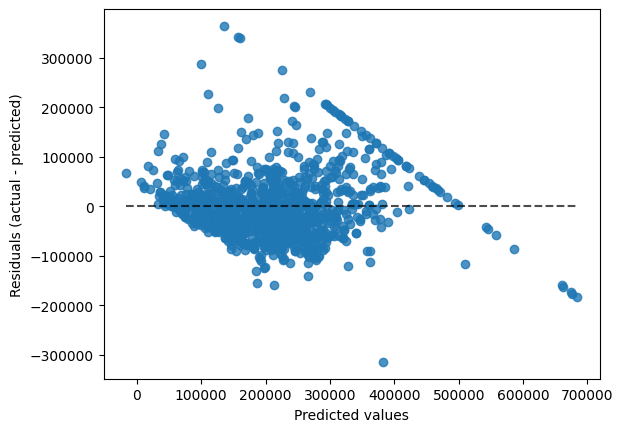

In [32]:
disp = PredictionErrorDisplay.from_estimator(lr, X_train_preprocessed, y_train)
plt.show()

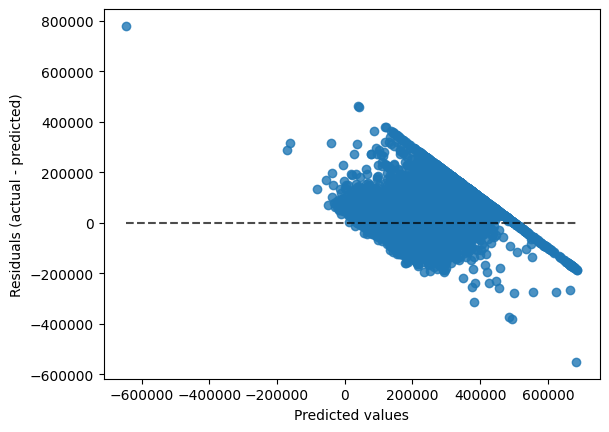

In [33]:
y_train_pred = lr.predict(X_train_preprocessed)
display = PredictionErrorDisplay(y_true=y_train, y_pred=y_train_pred)
display.plot()
plt.show()

In [35]:
vif_data = pd.DataFrame()
vif_data["feature"] = X_train_preprocessed.columns
vif_data["VIF"] = [variance_inflation_factor(X_train_preprocessed.values, i) for i in range(len(X_train_preprocessed.columns))]
vif_data

,feature,VIF
0,median_impute__total_bedrooms,26.250430
1,one_hot__ocean_proximity_<1H OCEAN,14824.652901
2,one_hot__ocean_proximity_INLAND,10353.049791
3,one_hot__ocean_proximity_ISLAND,7.182241
4,one_hot__ocean_proximity_NEAR BAY,3735.317887
5,one_hot__ocean_proximity_NEAR OCEAN,4385.227302
6,remainder__longitude,18.069818
7,remainder__latitude,19.905676
8,remainder__housing_median_age,1.324946
9,remainder__total_rooms,12.612498


In [37]:
y_train_pred

array([152509.00580402, 275107.20340662, 221473.59502257, ...,
       257257.2091145 , 311855.64618325,  26104.86312103])

In [41]:
X.columns.tolist()

['longitude',
 'latitude',
 'housing_median_age',
 'total_rooms',
 'total_bedrooms',
 'population',
 'households',
 'median_income',
 'ocean_proximity']

## Model evaluation

# Save

In [36]:
joblib.dump(preprocessor, f"preprocessor_0.pkl")
joblib.dump(lr, f"lr_0.pkl")

['lr_0.pkl']